<a href="https://colab.research.google.com/github/eudoxiamoura/gleidsonnew/blob/main/3DBreastSurface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas


In [1]:
!pip install geomdl==5.3.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 1.2 MB/s eta 0:00:00


In [3]:
import cv2 # OpenCV
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import glob

import os
from geomdl import NURBS
from geomdl import exchange
from geomdl import utilities
from geomdl import BSpline, NURBS
from geomdl.visualization import VisPlotly


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#copiando a pasta de trabalho, em outro colab
!cp -R '/content/gdrive/MyDrive/Colab Notebooks/Val_Mest_Simetria' Val_Mest_Simetria/

# Imagens

In [6]:
paths = glob.glob('/content/Val_Mest_Simetria/img/*.jpg')
paths_order = sorted(paths)

In [7]:
def loadImage(pathes, channels):
    imgs = []
    for i in pathes:
        imgs.append(cv2.imread(i, channels))
    return imgs

In [8]:
seg = loadImage(paths_order, 0)

In [9]:
img_name = ''.join(paths_order[0].split('/')[-1].split('.')[0].split('_')[-2])

In [10]:
img_name

'fundo'

## Binarizando

In [11]:
def showimg(array):
  # Mostrar várias imagens em uma grade
  plt.figure(figsize=(20, 20))
  for i in range(len(array)):
    plt.subplot(1, len(array), i+1)
    plt.imshow(array[i])
    plt.xticks([]),plt.yticks([])
  plt.show()

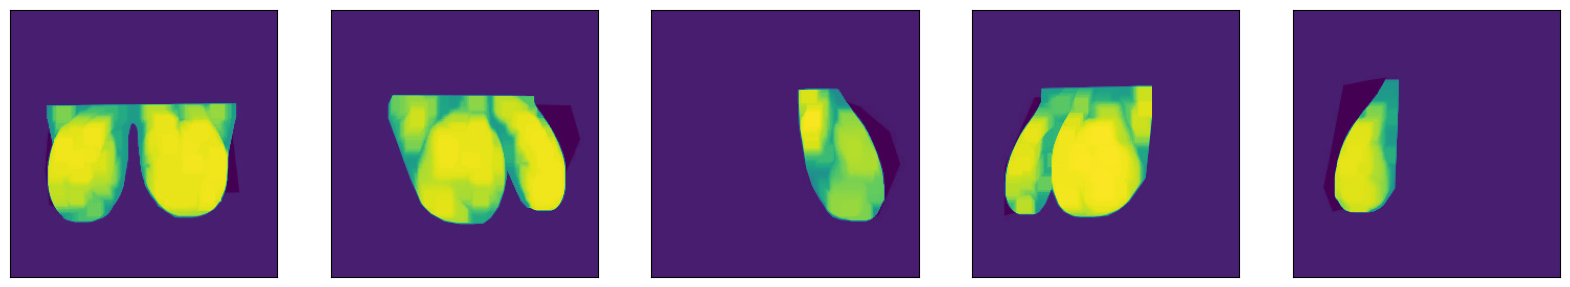

In [12]:
showimg(seg)

In [13]:
# duas forma de binarizar

def binImg(images):
  bin = []
  for img in seg:
    # Limiarização binária com valor único = 50
    ret, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin.append(thresh)

  return bin

# def binarizeImg(images):
#     bin = []
#     for i in images:
#         bin.append(i.copy())

#     for i in range(len(images)):
#         for j in range(len(images[i])):
#             for k in range(len(images[i][j])):
#                 if(images[i][j][k]>=50): # threshold definido como 50
#                     bin[i][j][k] = 255
#                 else:
#                     bin[i][j][k] = 0
#     return bin

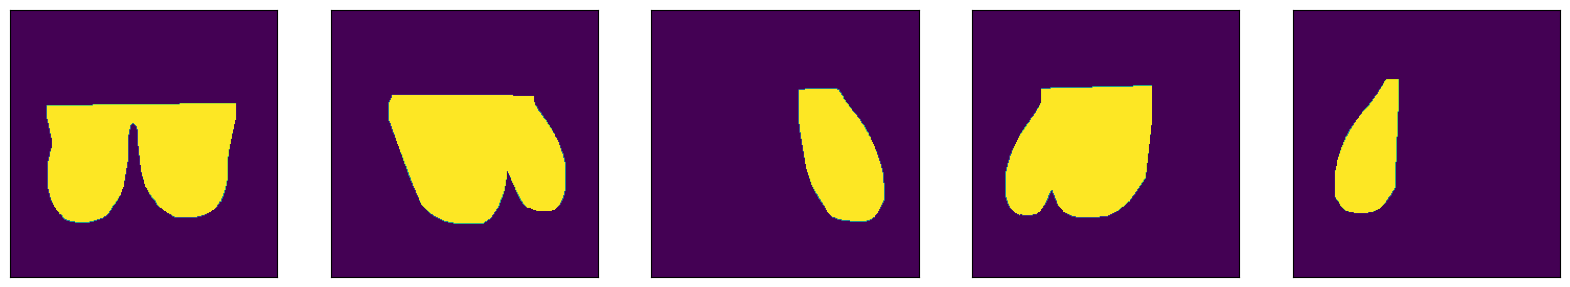

In [14]:
bin = binImg(seg)
showimg(bin)

# Processamento


## Localizando contornos

## Funcoes


In [15]:
def segmentImg(images, mask):
    newimg = []
    for i in images:
        newimg.append(i.copy())
    for i in range(len(images)):
        for j in range(len(images[i])):
            for k in range(len(images[i][j])):
                if(mask[i][j][k]==0):
                    newimg[i][j][k] = 0
    return newimg

In [16]:
import time
def drawContour(images):
    newimg = []
    start_time = time.time()
    for i in range(len(images)):
       ini = time.time()
       contours, hierarchy = cv2.findContours(images[i].astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
       c = max(contours, key = cv2.contourArea)
       M = cv2.moments(c)
       cX = int(M["m10"] / M["m00"])
       cY = int(M["m01"] / M["m00"])

       auximg = np.zeros((images[i].shape[0],images[i].shape[1],1), np.uint8)
       for j in range(len(c)-1):
           cv2.line(auximg, (c[j][0][0], c[j][0][1]), (c[j+1][0][0], c[j+1][0][1]), 255, 1)
       cv2.line(auximg, (c[len(c)-1][0][0], c[len(c)-1][0][1]), (c[0][0][0], c[0][0][1]), 255, 1)
      #  cv2.circle(auximg, (cX, cY), 5, (255, 255, 255), -1)
       newimg.append(auximg)

    return newimg

In [17]:
def imgROI(images):
    """
    Cria três matrizes vazias, down, left e right, com o mesmo tamanho da imagem. Essas matrizes serão usadas para armazenar informações sobre as regiões inferiores, esquerdas e direitas da imagem, respectivamente.
    Para a matriz down, percorre cada coluna da imagem de baixo para cima e verifica se o valor do pixel é diferente de zero. Se for diferente de zero, isso significa que foi encontrada uma região de interesse. Os pixels acima dessa região são definidos como 255 (branco) e os pixels abaixo são definidos como 0 (preto).
    Para a matriz left, percorre cada linha da imagem da esquerda para a direita e verifica se o valor do pixel é diferente de zero. Se for diferente de zero, isso significa que foi encontrada uma região de interesse. Os pixels à direita dessa região são definidos como 255 (branco) e os pixels à esquerda são definidos como 0 (preto).
    Para a matriz right, percorre cada linha da imagem da esquerda para a direita e verifica se o valor do pixel é diferente de zero. Se for diferente de zero, isso significa que foi encontrada uma região de interesse. Os pixels à esquerda dessa região são definidos como 255 (branco) e os pixels à direita são definidos como 0 (preto).
    Subtrai as matrizes left e right da matriz down, e atribui o resultado à imagem correspondente na lista newimg. Essa subtração cria uma imagem que destaca a região de interesse na imagem original.

    """
    newimg = []
    for i in images:
        newimg.append(i.copy())

    roi = []*len(newimg)

    #get clean image
    for i in range(len(images)):
        h = images[i].shape[0]
        w = images[i].shape[1]
        down = np.zeros((h,w,1), np.uint8)
        left = np.zeros((h,w,1), np.uint8)
        right = np.zeros((h,w,1), np.uint8)
        #Down
        for j in range(w):
            found = False
            for k in range(h-1, 0, -1):
                if(found):
                    down[k][j] = 0
                else:
                    if(images[i][k][j]!=0):
                        found = True
                        down[k][j] = 255
                    else:
                        down[k][j] = 0

        #Left
        for j in range(h):
            found = False
            for k in range(w-1, 0, -1):
                if(found):
                    left[j][k] = 0
                else:
                    if(images[i][j][k]!=0):
                        found = True
                        left[j][k] = 255
                    else:
                        left[j][k] = 0

        #Right
        for j in range(h):
            found = False
            for k in range(w):
                if(found):
                    right[j][k] = 0
                else:
                    if(images[i][j][k]!=0):
                        found = True
                        right[j][k] = 255
                    else:
                        right[j][k] = 0

        newimg[i] = cv2.subtract(cv2.subtract(down,left),right)
        #newimg[i] = cv2.add(cv2.add(cv2.bitwise_and(down,left),cv2.bitwise_and(down,right)),cv2.subtract(cv2.subtract(down,left),right))

    return newimg



In [18]:

    def imgLeftRightRoi(images):
      newimgleft = []
      newimgright = []
      for i in images:
          newimgleft.append(i.copy())
          newimgright.append(i.copy())


      #get clean image
      for i in range(len(images)):
          h = images[i].shape[0]
          w = images[i].shape[1]
          down = np.zeros((h,w,1), np.uint8)
          left = np.zeros((h,w,1), np.uint8)
          right = np.zeros((h,w,1), np.uint8)
          #Down
          for j in range(w):
              found = False
              for k in range(h-1, 0, -1):
                  if(found):
                      down[k][j] = 0
                  else:
                      if(images[i][k][j]!=0):
                          found = True
                          down[k][j] = 255
                      else:
                          down[k][j] = 0

          #Left
          for j in range(h):
              found = False
              for k in range(w-1, 0, -1):
                  if(found):
                      left[j][k] = 0
                  else:
                      if(images[i][j][k]!=0):
                          found = True
                          left[j][k] = 255
                      else:
                          left[j][k] = 0

          #Right
          for j in range(h):
              found = False
              for k in range(w):
                  if(found):
                      right[j][k] = 0
                  else:
                      if(images[i][j][k]!=0):
                          found = True
                          right[j][k] = 255
                      else:
                          right[j][k] = 0

          newimgleft[i] = cv2.subtract(left,down)
          newimgright[i] = cv2.subtract(right,down)

      pos_left = []
      pos_right = []
      for i in range(len(newimgleft)):
          h = newimgleft[i].shape[0]
          w = newimgleft[i].shape[1]
          b = []
          for j in range(w):
              for k in range(h):
                  if(newimgleft[i][k][j]!=0):
                      b.append((j,k))
          pos_left.append(b)
      for i in range(len(newimgright)):
          h = newimgright[i].shape[0]
          w = newimgright[i].shape[1]
          b = []
          for j in range(w):
              for k in range(h):
                  if(newimgright[i][k][j]!=0):
                      b.append((j,k))
          pos_right.append(b)


      return pos_left, pos_right

In [19]:
def ptsRoi(images, other):
    rois = [None]*len(images)

    newimg = []
    for i in other:
        newimg.append(i.copy())

    h = images[0].shape[0]
    w = images[0].shape[1]

    #0, 45, -45
    for i in [0, 1,3]:
        #Down
        intersec = [h,w]
        minleft = [0,0]
        minright = [0,0]

        #intercessao
        """
        O objetivo dessa parte do codigo é encontrar o ponto mais alto
        onde ocorre a interseção entre a linha vertical e
        a linha de borda em cada coluna da imagem.
        """
        for j in range(w):
            found = False
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0):
                    if(k<intersec[1]):
                        intersec = [j,k]
        #menor ponto pra direita
        for j in range(intersec[0], 0, -1):
            found = False
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0):
                    if(k>minright[1]):
                        minright = [j,k]
        #menor ponto pra esquerda
        for j in range(intersec[0], w, 1):
            found = False
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0):
                    if(k>minleft[1]):
                        minleft = [j,k]

        rois[i] = [(minright[0],minright[1]),(intersec[0],intersec[1]),(minleft[0],minleft[1])]

        cv2.circle(newimg[i], (intersec[0], intersec[1]), 3, 255, -1)
        cv2.circle(newimg[i], (minright[0], minright[1]), 3, 255, -1)
        cv2.circle(newimg[i], (minleft[0], minleft[1]), 3, 150, -1)
    #90, -90
    for i in [2, 4]:
        start = [0,0]
        min = [0,0]
        end = [0,0]

        #primeiro ponto pra direita
        found = False
        for j in range(w):
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0 and not found):
                    if(i==4):
                        start = [j,k]
                    else:
                        end = [j,k]
                    found = True

        #primeiro ponto para a esquerda
        found = False
        for j in range(w-1, 0, -1):
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0 and not found):
                    if(i==4):
                        end = [j,k]
                    else:
                        start = [j,k]
                    found = True
        #minimo entre eles
        for j in range(start[0], end[0], 1 if i==4 else -1):
            found = False
            for k in range(h-1, 0, -1):
                if(images[i][k][j]!=0):
                    if(k>min[1]):
                        min = [j,k]

        rois[i] = [(start[0],start[1]),(min[0],min[1]),(end[0],end[1])]

        cv2.circle(newimg[i], (start[0], start[1]), 5, 255, -1)
        cv2.circle(newimg[i], (min[0], min[1]), 5, 255, -1)
        cv2.circle(newimg[i], (end[0], end[1]), 5, 150, -1)

    return newimg, rois

In [20]:
def plot_contour_points(lists_of_points):
    colors = ['r', 'g', 'b', 'c', 'm']  # Cores diferentes para cada lista de pontos
    nomes = ['0 degrees', '45 degrees', '90 degrees', '-45 degrees', '-90 degrees']

    if len(lists_of_points) != len(colors):
        raise ValueError("O número de listas de pontos deve ser igual ao número de cores.")

    fig, ax = plt.subplots()

    for i, points in enumerate(lists_of_points):
        x, y, _ = zip(*points)  # Separa as coordenadas x e y
        ax.plot(x, y, marker='.', linestyle='', color=colors[i], label=nomes[i])

    ax.invert_yaxis()  # Inverter eixo y

    ax.set_xlabel('Axis X')
    ax.set_ylabel('Axis Y')
    ax.legend()
    ax.grid(True)
    ax.set_title('Breast contouring')

    plt.show()

def plot_contour_points_3d(lists_of_points):
    colors = ['r', 'g', 'b', 'c', 'm']  # Cores diferentes para cada lista de pontos

    if len(lists_of_points) != len(colors):
        raise ValueError("O número de listas de pontos deve ser igual ao número de cores.")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    nomes = ['0 degrees', '45 degrees', '90 degrees', '-45 degrees', '-90 degrees']

    for i, points in enumerate(lists_of_points):
        x, y, z = zip(*points)  # Separa as coordenadas x, y e z
        ax.plot(x, y, z, marker='.', linestyle='-', color=colors[i], label=nomes[i])

    ax.set_xlabel('Axis X')
    ax.set_ylabel('Axis Y')
    ax.set_zlabel('Axis Z')
    ax.legend()
    ax.grid(True)
    ax.set_title('Breast contouring')
    plt.show()

def plot_contour_points_4(lists_of_points):
    colors = ['g', 'b', 'c', 'm']  # Cores diferentes para cada lista de pontos

    if len(lists_of_points) != len(colors):
        raise ValueError("O número de listas de pontos deve ser igual ao número de cores.")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    nomes = ['45 degrees', '90 degrees', '-45 degrees', '-90 degrees']

    for i, points in enumerate(lists_of_points):
        x, y, z, _ = zip(*points)  # Separa as coordenadas x, y e z
        ax.plot(x, y, z, marker='.', linestyle='-', color=colors[i], label=nomes[i])

    ax.invert_yaxis()

    ax.set_xlabel('Axis X')
    ax.set_ylabel('Axis Y')
    ax.set_zlabel('Axis Z')
    ax.legend()
    ax.grid(True)
    ax.set_title('Breast contouring')
    plt.show()

def plot_contour_points_44(lists_of_points):
    colors = ['g', 'b', 'c', 'm', 'r', 'y']  # Cores diferentes para cada lista de pontos

    if len(lists_of_points) != len(colors):
        raise ValueError("O número de listas de pontos deve ser igual ao número de cores.")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    nomes = ['45 degrees', '90 degrees', '-45 degrees', '-90 degrees', '-135 degrees', '135 degrees', ]

    for i, points in enumerate(lists_of_points):
        x, y, z = zip(*points)  # Separa as coordenadas x, y e z
        ax.plot(x, y, z, marker='.', linestyle='-', color=colors[i], label=nomes[i])

    ax.invert_yaxis()
    ax.set_xlabel('Axis X')
    ax.set_ylabel('Axis Y')
    ax.set_zlabel('Axis Z')
    ax.legend()
    ax.grid(True)
    ax.set_title('Breast contouring')
    plt.show()

In [21]:
def getContour(images):
    newimg = []
    start_time = time.time()
    for i in range(len(images)):
       ini = time.time()
       contours, hierarchy = cv2.findContours(images[i].astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
       c = max(contours, key = cv2.contourArea)
       lp = []
       for j in range(len(c)):
           lp.append((c[j][0][0],c[j][0][1],0))
       newimg.append(lp)

    return newimg

## Contornos

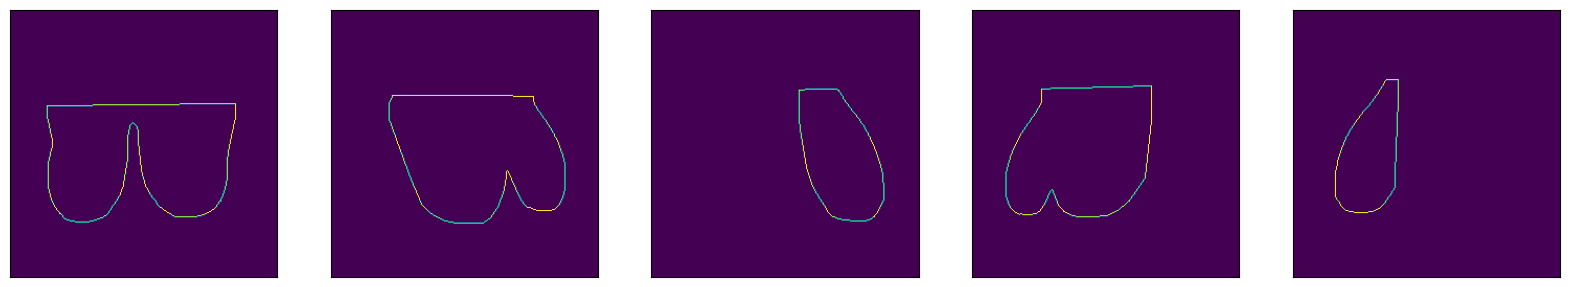

In [22]:
cont = drawContour(bin)
showimg(cont)

In [23]:
loi = imgROI(cont)

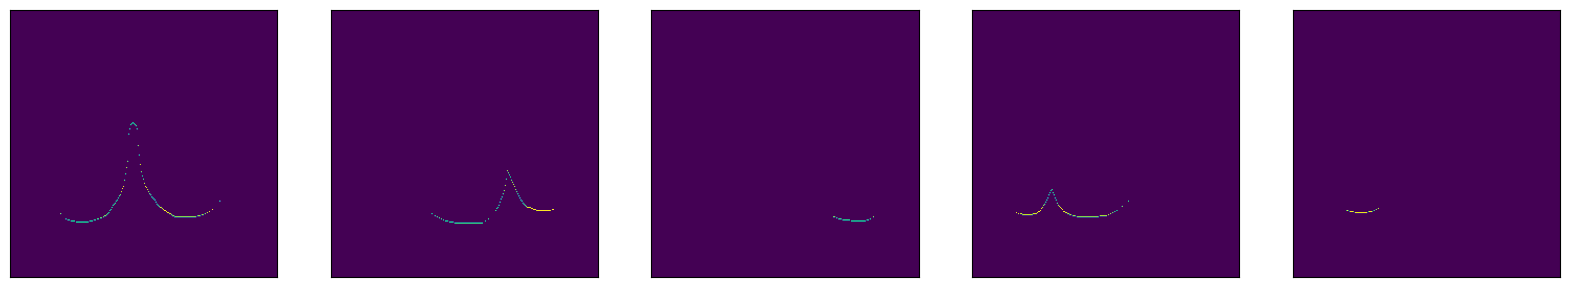

In [24]:
showimg(loi)

In [25]:
pleft, pright = imgLeftRightRoi(cont)

In [26]:
segmentada = segmentImg(seg, bin)

In [27]:
roi_img, roi_pts = ptsRoi(loi, segmentada)

In [28]:
ptContorno = getContour(bin)

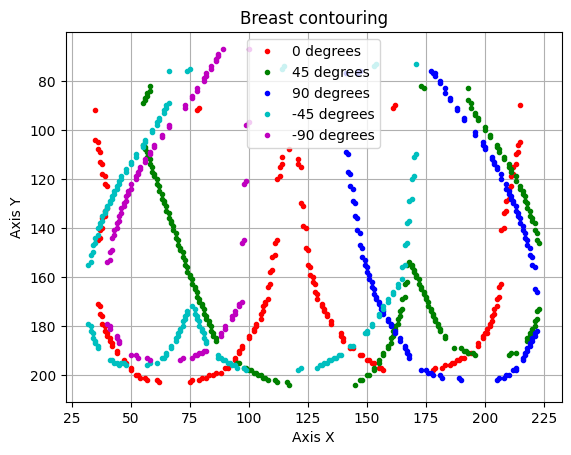

In [29]:
plot_contour_points(ptContorno)

## Movendo

## Pontos de interesse

In [30]:
#Distancia em X dos dois pontos inferiores da mama no angulo 0 (imagem da frente)
Dw = abs(roi_pts[0][0][0]-roi_pts[0][2][0])
# recebe a maior distancia entre o primeiro e ultimo ponto das imagens de 90 e -90 graus
dw = abs(roi_pts[2][0][0]-roi_pts[2][2][0])if abs(roi_pts[2][0][0]-roi_pts[2][2][0]) > abs(roi_pts[4][0][0]-roi_pts[4][2][0]) else abs(roi_pts[4][0][0]-roi_pts[4][2][0])
#soma o Y dos 3 pontos de interesse da imagem 0 e divide por dois
h = (roi_pts[0][1][1]+roi_pts[0][0][1]+roi_pts[0][2][1])/2

In [31]:
Dw, dw, h

(83, 38, 254.5)

In [32]:
roi_pts

[[(74, 203), (117, 108), (157, 198)],
 [(144, 204), (168, 154), (196, 192)],
 [(212, 198), (204, 202), (174, 198)],
 [(57, 196), (76, 172), (100, 198)],
 [(51, 192), (59, 194), (81, 190)]]

In [33]:
#adicionando coordenada Z
newroi_pts = []
for i in roi_pts:
    b = []
    for j in i:
        b.append(np.array([j[0], j[1], 0], float))
    newroi_pts.append(b)

In [34]:
newroi_pts

[[array([ 74., 203.,   0.]),
  array([117., 108.,   0.]),
  array([157., 198.,   0.])],
 [array([144., 204.,   0.]),
  array([168., 154.,   0.]),
  array([196., 192.,   0.])],
 [array([212., 198.,   0.]),
  array([204., 202.,   0.]),
  array([174., 198.,   0.])],
 [array([ 57., 196.,   0.]),
  array([ 76., 172.,   0.]),
  array([100., 198.,   0.])],
 [array([ 51., 192.,   0.]),
  array([ 59., 194.,   0.]),
  array([ 81., 190.,   0.])]]

## Transladando




In [35]:
def moveToDistancePts(points, topoint):
    return np.array(topoint)-np.array(points)

In [36]:
def translatePts(points, x=10, y=0, z=0):
    arrmat = np.array([[1,0,0,x],
                       [0,1,0,y],
                       [0,0,1,z],
                       [0,0,0,1]])
    newpts = []
    for lpt in points:
        listpts = []
        for pt in lpt:
            arrpts = np.array([pt[0], pt[1], pt[2], 1])
            listpts.append(np.matmul(arrmat, arrpts)[0:3])
        newpts.append(listpts)

    return newpts

In [37]:
import math
def rotatePts(points, angle=90, axis='x'):
    angle = (angle*math.pi)/180
    c = math.cos(angle)
    s = math.sin(angle)
    #z
    arrmat = np.array([[c,-s,0,0],
                       [s,c,0,0],
                       [0,0,1,0],
                       [0,0,0,1]], float)
    if axis=='x':
        arrmat = np.array([[1,0,0,0],
                       [0,c,-s,0],
                       [0,s,c,0],
                       [0,0,0,1]], float)
    elif axis == 'y':
        arrmat = np.array([[c,0,s,0],
                       [0,1,0,0],
                       [-s,0,c,0],
                       [0,0,0,1]], float)

    newpts = []
    for lpt in points:
        listpts = []
        for pt in lpt:
            arrpts = np.array([pt[0], pt[1], pt[2], 1], float)
            listpts.append(np.matmul(arrmat, arrpts))
        newpts.append(listpts)

    return newpts

## Origem

In [38]:
move0 = moveToDistancePts([roi_pts[0][1][0], roi_pts[0][1][1], 0], [0, 0, 0])#p2
move45 = moveToDistancePts([roi_pts[1][2][0], roi_pts[1][2][1], 0], [0, 0, 0])#p3
move90 = moveToDistancePts([roi_pts[2][1][0], roi_pts[2][1][1], 0], [0, 0, 0])#p2
movem45 = moveToDistancePts([roi_pts[3][0][0], roi_pts[3][0][1], 0], [0, 0, 0])#p1
movem90 = moveToDistancePts([roi_pts[4][1][0], roi_pts[4][1][1], 0], [0, 0, 0])#p2

In [39]:
ptCont0 = translatePts(ptContorno, x=move0[0], y=move0[1], z=move0[2])
ptCont45 = translatePts(ptContorno, x=move45[0], y=move45[1], z=move45[2])
ptCont90 = translatePts(ptContorno, x=move90[0], y=move90[1], z=move90[2])
ptContm45 = translatePts(ptContorno, x=movem45[0], y=movem45[1], z=movem45[2])
ptContm90 = translatePts(ptContorno, x=movem90[0], y=movem90[1] , z=movem90[2])

In [40]:
ptCont0

[[array([ 45, -18,   0]),
  array([ 44, -17,   0]),
  array([-38, -17,   0]),
  array([-39, -16,   0]),
  array([-82, -16,   0]),
  array([-82,  -4,   0]),
  array([-81,  -3,   0]),
  array([-81,   0,   0]),
  array([-80,   1,   0]),
  array([-80,   5,   0]),
  array([-79,   6,   0]),
  array([-79,  10,   0]),
  array([-78,  11,   0]),
  array([-78,  14,   0]),
  array([-77,  15,   0]),
  array([-77,  24,   0]),
  array([-78,  25,   0]),
  array([-78,  27,   0]),
  array([-79,  28,   0]),
  array([-79,  32,   0]),
  array([-80,  33,   0]),
  array([-80,  36,   0]),
  array([-81,  37,   0]),
  array([-81,  63,   0]),
  array([-80,  64,   0]),
  array([-80,  67,   0]),
  array([-79,  68,   0]),
  array([-79,  71,   0]),
  array([-78,  72,   0]),
  array([-78,  74,   0]),
  array([-77,  75,   0]),
  array([-77,  76,   0]),
  array([-76,  77,   0]),
  array([-76,  78,   0]),
  array([-75,  79,   0]),
  array([-75,  80,   0]),
  array([-73,  82,   0]),
  array([-73,  83,   0]),
  array([-70

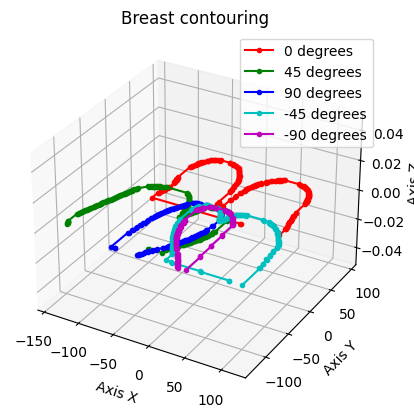

In [41]:
plot_contour_points_3d([ptCont0[0], ptCont45[1], ptCont90[2], ptContm45[3], ptContm90[4]])

In [42]:
ptRoi0 = translatePts(newroi_pts, x=move0[0], y=move0[1], z=move0[2])
ptRoi45 = translatePts(newroi_pts, x=move45[0], y=move45[1], z=move45[2])
ptRoi90 = translatePts(newroi_pts, x=move90[0], y=move90[1], z=move90[2])
ptRoim45 = translatePts(newroi_pts, x=movem45[0], y=movem45[1], z=movem45[2])
ptRoim90 = translatePts(newroi_pts, x=movem90[0], y=movem90[1], z=movem90[2])

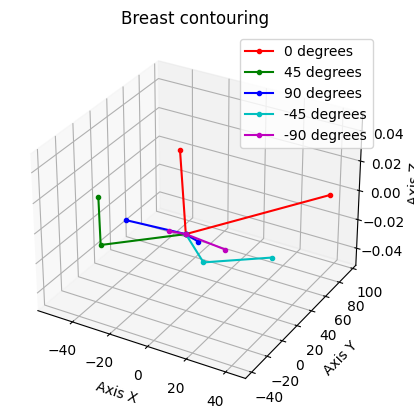

In [43]:
plot_contour_points_3d([ptRoi0[0], ptRoi45[1], ptRoi90[2], ptRoim45[3], ptRoim90[4]])

In [44]:
# rotaciona todo mundo em graus
ptContRotate45 = rotatePts(ptCont45, angle=45, axis='y')
#cria um contorno auxiliar com base no de 45
ptContRotate45aux = rotatePts(ptCont45, angle=135, axis='y')
ptContRotate90 = rotatePts(ptCont90, angle=90, axis='y')
ptContRotatem45 = rotatePts(ptContm45, angle=-45, axis='y')
ptContRotatem45aux = rotatePts(ptContm45, angle=-135, axis='y')
ptContRotatem90 = rotatePts(ptContm90, angle=-90, axis='y')

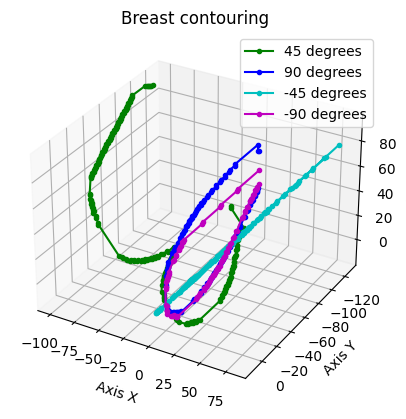

In [45]:
plot_contour_points_4([ptContRotate45[1], ptContRotate90[2], ptContRotatem45[3], ptContRotatem90[4]])

In [46]:
ptRoiRotate45 = rotatePts(ptRoi45, angle=45, axis='y')
ptRoiRotate45aux = rotatePts(ptRoi45, angle=135, axis='y')
ptRoiRotate90 = rotatePts(ptRoi90, angle=90, axis='y')
p390 = ptRoiRotate90[2][2][2]
ptRoiRotatem45aux = rotatePts(ptRoim45, angle=-135, axis='y')
ptRoiRotatem90 = rotatePts(ptRoim90, angle=-90, axis='y')
p3m90 = ptRoiRotatem90[4][2][2]

numeros = np.array([p390, p3m90])
cortar = np.mean(numeros)

In [47]:
movepts45 = moveToDistancePts([0, 0, 0], [ptRoi0[0][2][0], ptRoi0[0][2][1], 0])
movepts90 = moveToDistancePts([0, 0, 0], [ptRoi0[0][0][0], ptRoi0[0][0][1], 0])
moveptsm45 = moveToDistancePts([0, 0, 0], [ptRoi0[0][0][0], ptRoi0[0][0][1], 0])
moveptsm90 = moveToDistancePts([0, 0, 0], [ptRoi0[0][2][0], ptRoi0[0][2][1], 0])

In [48]:
ptContRotate45 = translatePts(ptContRotate45, x=movepts45[0], y=movepts45[1], z=movepts45[2])
ptContRotate45aux = translatePts(ptContRotate45aux, x=movepts45[0], y=movepts45[1], z=movepts45[2])
ptContRotate90 = translatePts(ptContRotate90, x=movepts90[0], y=movepts90[1], z=movepts90[2])
ptContRotatem45 = translatePts(ptContRotatem45, x=moveptsm45[0], y=moveptsm45[1], z=moveptsm45[2])
ptContRotatem45aux = translatePts(ptContRotatem45aux, x=moveptsm45[0], y=moveptsm45[1], z=moveptsm45[2])
ptContRotatem90 = translatePts(ptContRotatem90, x=moveptsm90[0], y=moveptsm90[1], z=moveptsm90[2])

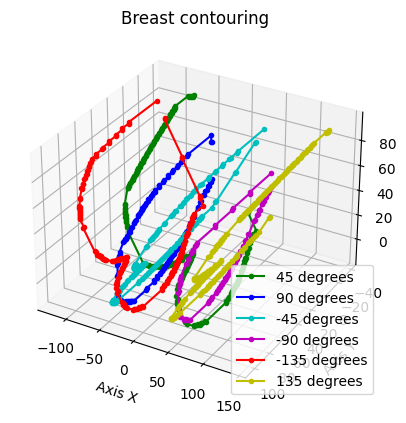

In [49]:
plot_contour_points_44([ptContRotate45[1], ptContRotate90[2], ptContRotatem45[3], ptContRotatem90[4], ptContRotatem45aux[3], ptContRotate45aux[1]])


In [50]:
ptCont0 = translatePts(ptCont0, x=-move0[0], y=-move0[1], z=-move0[2])
ptRoi0 = translatePts(ptRoi0, x=-move0[0], y=-move0[1], z=-move0[2])

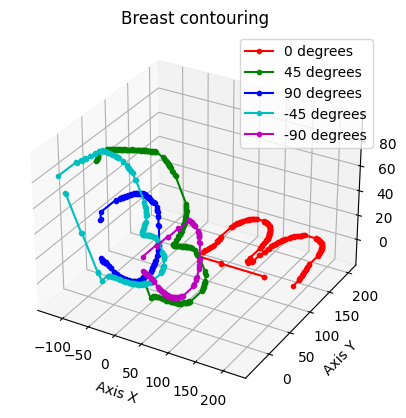

In [51]:
plot_contour_points_3d([ptCont0[0], ptContRotate45[1], ptContRotate90[2], ptContRotatem45aux[3], ptContRotatem90[4]])

## Cortando pontos

In [52]:

b = []
left = []
right = []
for i in ptCont0[0]:
    if i[0] < ptRoi0[0][0][0] or i[0] > ptRoi0[0][2][0]:
        b.append(i)
    if i[0] < ptRoi0[0][0][0]:
        min = 5
        for j in pright[0]:
            if np.linalg.norm(i-np.array((j[0], j[1], 0))) < min:
                min = np.linalg.norm(i-np.array((j[0], j[1], 0)))
        if min < 5:
            left.append(i)
    if i[0] > ptRoi0[0][2][0]:
        min = 5
        for j in pleft[0]:
            if np.linalg.norm(i-np.array((j[0], j[1], 0))) < min:
                min = np.linalg.norm(i-np.array((j[0], j[1], 0)))
        if min < 5:
            right.append(i)

ptCont0[0] = b

for ponto in ptCont0[0]:
        ponto[2] = cortar

In [53]:
menorYleft = left[0]  # Assume o primeiro ponto como o maior inicialmente
for ponto in left:
        if ponto[1] < menorYleft[1]:  # Verifica se o valor de y deste ponto é maior que o maior encontrado até agora
            menorYleft = ponto

menorYright = right[0]  # Assume o primeiro ponto como o maior inicialmente
for ponto in right:
        if ponto[1] < menorYright[1]:  # Verifica se o valor de y deste ponto é maior que o maior encontrado até agora
            menorYright = ponto

numeros = np.array([menorYleft[1], menorYright[1]])
cortar_y = np.mean(numeros)

In [54]:

miny = ptCont0[0][0]
maxy = ptCont0[0][0]

for i in ptCont0[0]:
    if (i[1] < miny[1]):
        miny = i
    if (i[1] > maxy[1]):
        maxy = i

middle = [[np.array([ptRoi0[0][1][0], miny[1], 0]), np.array(
    [ptRoi0[0][1][0], miny[1], 0]), ptRoi0[0][1], ptRoi0[0][1], ptRoi0[0][1]]]*5

In [55]:
def getContourThreshold(contour, t):
    #pontos acima do limiar de z <= 0
    newcnt = []
    for i in contour:
        b = []
        for j in i:
            if j[2] <= t:
                b.append(j)
        newcnt.append(b)
    return newcnt

In [56]:
newptContRotate45 = getContourThreshold(ptContRotate45, 0)
newptContRotate45aux = getContourThreshold(ptContRotate45aux, 0)
newptContRotate90 = getContourThreshold(ptContRotate90, cortar)#
newptContRotatem45 = getContourThreshold(ptContRotatem45, 0)
newptContRotatem45aux = getContourThreshold(ptContRotatem45aux, 0)
newptContRotatem90 = getContourThreshold(ptContRotatem90, cortar)#

In [57]:
newptContRotate45 = translatePts(newptContRotate45, x=-move0[0], y=-move0[1], z=-move0[2])
newptContRotate45aux = translatePts(newptContRotate45aux, x=-move0[0], y=-move0[1], z=-move0[2])
newptContRotate90 = translatePts(newptContRotate90, x=-move0[0], y=-move0[1], z=-move0[2])
newptContRotatem45 = translatePts(newptContRotatem45, x=-move0[0], y=-move0[1], z=-move0[2])
newptContRotatem45aux = translatePts(newptContRotatem45aux, x=-move0[0], y=-move0[1], z=-move0[2])
newptContRotatem90 = translatePts(newptContRotatem90, x=-move0[0], y=-move0[1], z=-move0[2])

In [58]:

def showPoints2(points):
    # v= np.array([[1,2,3], [4,5,6], [7,8,9]])
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xticks(np.arange(-500,500,50))
    ax.set_yticks(np.arange(-500,500,50))
    ax.set_zticks(np.arange(-500,500,50))


    # rótulos e título se desejar
    ax.set_xlabel('Eixo X')
    ax.set_ylabel('Eixo Y')
    ax.set_zlabel('Eixo Z')
    ax.set_title('Gráfico 3D')

    arr = ['frontal', 'right oblique curve', 'total right curve', 'left oblique lateral curve', 'total left curve']
    # image.showPoints2([ptCont0, newptContRotate45, newptContRotate90, newptContRotatem45, newptContRotatem90, newptContRotate45aux, newptContRotatem45aux, middle, left, right])
    # print(points)
    for i in [1, 2, 3, 4]:
        ax.plot([i[0] for i in points[i][i]],
            [i[1] for i in points[i][i]],
            [i[2] for i in points[i][i]], marker='x', label=arr[i] if i<len(arr) else 'XXXXX')

    ax.plot([i[0] for i in points[5][1]],
        [i[1] for i in points[5][1]],
        [i[2] for i in points[5][1]], label='right oblique auxiliary curve')

    ax.plot([i[0] for i in points[6][3]],
        [i[1] for i in points[6][3]],
        [i[2] for i in points[6][3]], label='left oblique auxiliary curve')

    ax.plot([i[0] for i in points[7][0]],
        [i[1] for i in points[7][0]],
        [i[2] for i in points[7][0]], label='central auxiliary curve')

    ax.plot([i[0] for i in points[8]],
        [i[1] for i in points[8]],
        [i[2] for i in points[8]], marker='x', label='left frontal curve')

    ax.plot([i[0] for i in points[9]],
        [i[1] for i in points[9]],
        [i[2] for i in points[9]], marker='x', label='right frontal curve')



    # plt.legend()
    plt.show()



In [59]:
ptCont0, newptContRotate45, newptContRotate90, newptContRotatem45, newptContRotatem90, newptContRotate45aux, newptContRotatem45aux, middle, left, right


([[array([162,  90,  26]),
   array([161,  91,  26]),
   array([35, 92, 26]),
   array([ 35, 104,  26]),
   array([ 36, 105,  26]),
   array([ 36, 108,  26]),
   array([ 37, 109,  26]),
   array([ 37, 113,  26]),
   array([ 38, 114,  26]),
   array([ 38, 118,  26]),
   array([ 39, 119,  26]),
   array([ 39, 122,  26]),
   array([ 40, 123,  26]),
   array([ 40, 132,  26]),
   array([ 39, 133,  26]),
   array([ 39, 135,  26]),
   array([ 38, 136,  26]),
   array([ 38, 140,  26]),
   array([ 37, 141,  26]),
   array([ 37, 144,  26]),
   array([ 36, 145,  26]),
   array([ 36, 171,  26]),
   array([ 37, 172,  26]),
   array([ 37, 175,  26]),
   array([ 38, 176,  26]),
   array([ 38, 179,  26]),
   array([ 39, 180,  26]),
   array([ 39, 182,  26]),
   array([ 40, 183,  26]),
   array([ 40, 184,  26]),
   array([ 41, 185,  26]),
   array([ 41, 186,  26]),
   array([ 42, 187,  26]),
   array([ 42, 188,  26]),
   array([ 44, 190,  26]),
   array([ 44, 191,  26]),
   array([ 47, 194,  26]),
   a

## Normalizando

In [60]:
def addNewPoint2Array(array, ref):
    if (array[0][1] > ref).all():
        array.insert(0, np.array([array[0][0], ref, 0], float))
    return array


In [61]:
left = addNewPoint2Array(left, middle[0][0][1])

newptContRotate45 = [newptContRotate45[1][i]for i in range(len(newptContRotate45[1])-1, -1, -1)]
newptContRotate45 = addNewPoint2Array(newptContRotate45, middle[0][0][1])

newptContRotate90 = [newptContRotate90[2][i]for i in range(len(newptContRotate90[2])-1, -1, -1)]
newptContRotate90 = addNewPoint2Array(newptContRotate90, middle[0][0][1])

newptContRotate45aux = [newptContRotate45aux[1][i] for i in range(len(newptContRotate45aux[1])-1, -1, -1)]
newptContRotate45aux = addNewPoint2Array(newptContRotate45aux, middle[0][0][1])

newptContRotatem45aux = addNewPoint2Array(newptContRotatem45aux[3], middle[0][0][1])

newptContRotatem90 = addNewPoint2Array(newptContRotatem90[4], middle[0][0][1])

newptContRotatem45 = addNewPoint2Array(newptContRotatem45[3], middle[0][0][1])

right = [right[i] for i in range(len(right)-1, -1, -1)]
right = addNewPoint2Array(right, middle[0][0][1])

# BSpline


In [62]:
from geomdl import BSpline, NURBS
from geomdl import utilities
from geomdl import exchange


from geomdl import operations


In [63]:

def findBSpline(ponto):
    # Create a B-Spline curve instance
    curve = BSpline.Curve()

    # Set up curve
    curve.degree = 4
    curve.ctrlpts = ponto

    # Auto-generate knot vector
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))

    # Set evaluation delta
    curve.delta = 0.001

    # Evaluate curve
    curve.evaluate()

    return curve.evalpts

In [64]:
middle[0]

[array([117.,  90.,   0.]),
 array([117.,  90.,   0.]),
 array([117., 108.,   0.]),
 array([117., 108.,   0.]),
 array([117., 108.,   0.])]

In [65]:
left = [ponto.tolist() for ponto in left]
newptContRotate45 = [ponto.tolist() for ponto in newptContRotate45]
newptContRotate90 = [ponto.tolist() for ponto in newptContRotate90]
newptContRotate45aux = [ponto.tolist() for ponto in newptContRotate45aux]
middle = [ponto.tolist() for ponto in middle[0]]
newptContRotatem45aux = [ponto.tolist() for ponto in newptContRotatem45aux]
newptContRotatem90 = [ponto.tolist() for ponto in newptContRotatem90]
newptContRotatem45 = [ponto.tolist() for ponto in newptContRotatem45]
right = [ponto.tolist() for ponto in right]


In [66]:
p0 = findBSpline(left)
p1 = findBSpline(newptContRotate45)
p2 = findBSpline(newptContRotate90)
p3 = findBSpline(newptContRotate45aux)
p4 = findBSpline(middle)
p5 = findBSpline(newptContRotatem45aux)
p6 = findBSpline(newptContRotatem90)
p7 = findBSpline(newptContRotatem45)
p8 = findBSpline(right)

# nova


In [67]:
def saveFileFullPts(array):
  # f = []
  # for i in range(len(array[0])):
  #     for j in range(len(array)):
  #         f.append(str(array[j][i][0])+','+str(array[j][i][1])+','+str(array[j][i][2])+','+str(1.0))
  # return f

  f = open("\_ctrlpoints.cptw", "w")
  for i in range(len(array[0])):
      for j in range(len(array)):
          f.write(str(array[j][i][0])+','+str(array[j][i][1])+','+str(array[j][i][2])+','+str(1.0))
          if j<len(array)-1:
              f.write(";")
      f.write("\n")
  f.close()

In [68]:
array = [p0, p7, p2, p5, p4, p3, p6, p1, p8]
f = saveFileFullPts(array)


In [70]:

surf = NURBS.Surface()

# Set degrees
surf.degree_u = 3
surf.degree_v = 6

surf.set_ctrlpts(*exchange.import_txt("\_ctrlpoints.cptw", two_dimensional=True)) # type: ignore

# p0 = findBSpline("/content/0.cpt")

surf.knotvector_u = utilities.generate_knot_vector(surf.degree_u, len(p0))
surf.knotvector_v = utilities.generate_knot_vector(surf.degree_v, 9)

surf.delta = 0.01

surf.evaluate()

vis_config = VisPlotly.VisConfig(use_renderer = True, bbox=True )
vis_comp = VisPlotly.VisSurface(vis_config)
surf.vis = vis_comp
surf.render()

pass

